# Track + analyze football matches through broadcast video using
# YOLOv5 + ByteTrack + HSV Classifier

### Connect this colab notebook with Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check the GPU device info

In [2]:
!nvidia-smi

Mon Jul  3 08:42:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Get root direction

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Clone the yolov5 github from ultralytics into your drive

In [ ]:
%cd {HOME}/drive/MyDrive/
!git clone https://github.com/ultralytics/yolov5

/content/drive/MyDrive
fatal: destination path 'yolov5' already exists and is not an empty directory.


After cloned yolov5 github, you have to open yolov5/models/common.py file in yolov5 folder in your drive.

You need to change the 'stride' parameter in line 338 from 32 to 64

Because the default code is for P5 version but my model is P6 version which use stride = 64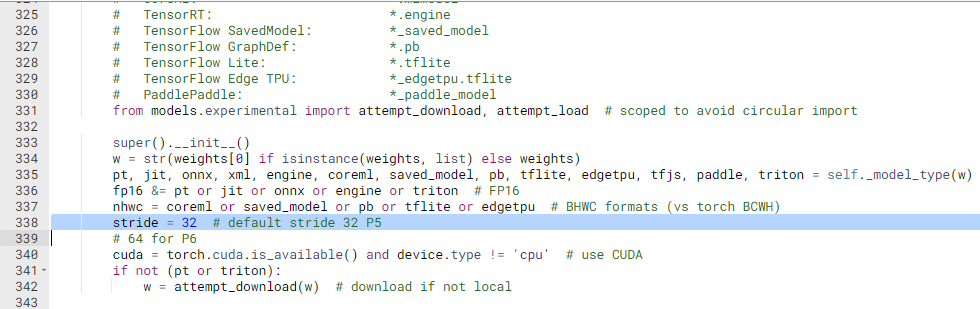

Then restart the runtime to run perfectly. From now, you don't need to clone and change anything in the yolov5 folder.

Install requirements packages to run yolov5

In [4]:
%cd {HOME}/drive/MyDrive/yolov5
!pip install -qr requirements.txt

import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.2/78.2 GB disk)


### Clone ByteTrack github for tracking task

In [11]:
%cd {HOME}/drive/MyDrive/
!git clone https://github.com/ifzhang/ByteTrack.git

/content/drive/MyDrive
Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
Updating files: 100% (229/229), done.


Install requirement packages for ByteTrack

Some other packages are for requirement package.

In [5]:
%cd {HOME}/drive/MyDrive/ByteTrack

# !sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt
!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install -q loguru lap
!pip install onemetric --quiet
from IPython import display
display.clear_output()

### Clone my github to run analytics and annotations

In [6]:
%cd /content/drive/MyDrive
!rm -rf Football-Match-Analysis
!git clone https://github.com/gnurt2041/Football-Match-Analysis.git

/content/drive/MyDrive
Cloning into 'Football-Match-Analysis'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 420 (delta 178), reused 136 (delta 69), pack-reused 86
Receiving objects: 100% (420/420), 950.53 KiB | 7.73 MiB/s, done.
Resolving deltas: 100% (202/202), done.


### Arguments for run
In google colab you can't use arguments from module, so you have to write and run it in code cell

In [7]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument(
    "--source",
    default="./test.mp4",
    type=str,
    help="Path to the input "
)
parser.add_argument(
    "--model", default="/model.pt", type=str, help="Path to the model"
)
parser.add_argument(
    "--possession",
    action="store_false",
    help="Enable possession counter"
)
parser.add_argument(
    "--possession_threshold",
    type=int,
    default=15,
    help="Amount of consecutive frames new team has to have the ball in order to change possession"
)
parser.add_argument(
    "--ball_conf",
    type=float,
    default=0.4,
    help="Ball confidence threshold"
)
parser.add_argument(
    "--teams_name",
    nargs='+',
    type=str,
    default=['MUN','SEV'],
    help="Name of two teams"
)
parser.add_argument(
    "--color_home",
    nargs='+',
    type=str,
    default=['red','blue','sky_blue','blueish_red'],
    help="Colors of two teams and refee, format: [c1,c2] -> [T1,T1]"
)
parser.add_argument(
    "--color_away",
    nargs='+',
    type=str,
    default=['white','yellow'],
    help="Colors of two teams and refee, format: [c3,c4] -> [T2,T2]"
)
parser.add_argument(
    "--color_referee",
    type=str,
    default='black',
    help="Colors of two teams and refee, format: [c5] -> [R]"
)
parser.add_argument(
    "--colors_draw",
    nargs='+',
    type=str,
    default=['blue','salmon','yellow'],
    help="Colors to draw classification of teams and refee, format: [c1,c2,c3] -> [T1,T2,R]"
)
parser.add_argument(
    "--board_colors",
    nargs='+',
    type=tuple,
    default=['',''],
    help="Colors to draw classification of teams and refee, format: [c1,c2,c3] -> [T1,T2,R]"
)
parser.add_argument(
    "--text_colors",
    nargs='+',
    type=tuple,
    default=['',''],
    help="Colors to draw classification of teams and refee, format: [c1,c2,c3] -> [T1,T2,R]"
)
args = parser.parse_args(args=[])
print(args)

Namespace(source='./test.mp4', model='/model.pt', possession=True, possession_threshold=15, ball_conf=0.4, teams_name=['MUN', 'SEV'], color_home=['red', 'blue', 'sky_blue', 'blueish_red'], color_away=['white', 'yellow'], color_referee='black', colors_draw=['blue', 'salmon', 'yellow'], board_colors=['', ''], text_colors=['', ''])


### Download model weight and test video

Use torch hub to load model

In [21]:
%cd {HOME}/drive/MyDrive
!gdown https://drive.google.com/uc?id=1P4b2Hgw3_9RMvp5sWIW0ZwB222KoHzhR&export=download

/content/drive/MyDrive
Downloading...
From: https://drive.google.com/uc?id=1P4b2Hgw3_9RMvp5sWIW0ZwB222KoHzhR
To: /content/drive/MyDrive/bestx.pt
100% 281M/281M [00:01<00:00, 238MB/s]


In [8]:
args.model = f"{HOME}/drive/MyDrive/bestx.pt"

In [9]:
%cd {HOME}/drive/MyDrive/yolov5
import torch
model = torch.hub.load('.', 'custom', args.model, source='local')

/content/drive/MyDrive/yolov5


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [10]:
model.names

{0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}

Download test video from my drive

You can use your test video but pay attention to camera angle conditions

In [11]:
!pip install youtube-dl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.2 MB/s eta 0:00:00


In [12]:
%cd {HOME}/drive/MyDrive/Football-Match-Analysis/football
!youtube-dl -o "%(title)s" https://drive.google.com/file/d/1k37G4KKscLNqZRa9fHHOEBe47HPhNz0b/view?usp=sharing

/content/drive/MyDrive/Football-Match-Analysis/football
[GoogleDrive] 1k37G4KKscLNqZRa9fHHOEBe47HPhNz0b: Downloading webpage
[GoogleDrive] 1k37G4KKscLNqZRa9fHHOEBe47HPhNz0b: Requesting source file
[download] Destination: mun_sev_test.mp4
[download] 100% of 75.33MiB in 00:00


### All necessary modules and libaries

In [13]:
import sys
sys.path.append(f'{HOME}/drive/MyDrive/ByteTrack')
sys.path.append(f'{HOME}/drive/MyDrive/Football-Match-Analysis/football')

In [14]:
import cv2
import matplotlib
from analysis.filter import filters
from analysis.hsv_classifier import HSVClassifier
from analysis.inertia_classifier import InertiaClassifier
from analysis.colors import Color
from draw.annotate import BaseAnnotator
from draw.marker import MarkerAnntator
from util.detection import (
    Detection,
    filter_class,
    filter_classification,
    true_ball
)
from util.track import (
    BYTETrackerArgs,
    detections2boxes,
    tracks2boxes,
    match_detections_with_tracks
)
from draw.draw_possession import (
    get_possession_background,
    draw_possession_counter
)
from analysis.possession import (
    get_player_in_possession,
    get_team_in_possession,
    inertia_possession
)
from util.video import Video

from yolox.tracker.byte_tracker import BYTETracker

### Color for annotate and board possession

In [15]:
# annotation color
# home color
HOME_COLOR_HEX = matplotlib.colors.cnames[args.colors_draw[0]]
HOME_COLOR = Color.from_hex_string(HOME_COLOR_HEX)

# away color
AWAY_COLOR_HEX = matplotlib.colors.cnames[args.colors_draw[1]]
AWAY_COLOR = Color.from_hex_string(AWAY_COLOR_HEX)

# refree color
REFEREE_COLOR_HEX = matplotlib.colors.cnames[args.colors_draw[2]]
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

# possession board and text color
HOME_BOARD_HEX = matplotlib.colors.cnames['cornflowerblue']
args.board_colors[0] = Color.from_hex_string(HOME_BOARD_HEX).bgr_tuple
HOME_TEXT_HEX = matplotlib.colors.cnames['white']
args.text_colors[0] = Color.from_hex_string(HOME_TEXT_HEX).bgr_tuple
AWAY_BOARD_HEX = matplotlib.colors.cnames['royalblue']
args.board_colors[1] = Color.from_hex_string(AWAY_BOARD_HEX).bgr_tuple
AWAY_TEXT_HEX = matplotlib.colors.cnames['white']
args.text_colors[1] = Color.from_hex_string(AWAY_TEXT_HEX).bgr_tuple

### Color for marker of ball and closest player

In [16]:
# marker color
MARKER_CONTOUR_COLOR_HEX = "000000"
MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# player maker color
PLAYER_MARKER_FILL_COLOR_HEX = "FF0000"
PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# ball maker color
BALL_MERKER_FILL_COLOR_HEX = "00FF00"
BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MERKER_FILL_COLOR_HEX)

# marker parameters
MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 15
MARKER_HEIGHT = 15
MARKER_MARGIN = 7

# distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 40

### Path for test video and board possession image

In [17]:
args.source = f"{HOME}/drive/MyDrive/Football-Match-Analysis/football/mun_sev_test.mp4"
BOARD_IMG_PATH = f"{HOME}/drive/MyDrive/Football-Match-Analysis/football/draw/board_possession.png"

### Init some setting for running
### Include: video, annotators, hsv classifier, ByteTrack and possession per team

In [18]:
# initiate video reader and writer
video = Video(input_path=args.source)

# initiate annotators
THICKNESS = 4
player_home_annotator = BaseAnnotator(
    colors = HOME_COLOR,thickness=THICKNESS)
player_away_annotator = BaseAnnotator(
    colors = AWAY_COLOR,thickness=THICKNESS)
referee_annotator = BaseAnnotator(
    colors = REFEREE_COLOR,thickness=THICKNESS)

ball_marker_annotator = MarkerAnntator(
    color=BALL_MARKER_FILL_COLOR)
player_in_possession_marker_annotator = MarkerAnntator(
    color=PLAYER_MARKER_FILL_COLOR)

# HSV Classifier
hsv_filters = filters(args)
hsv_classifier = HSVClassifier(filters=hsv_filters)
# Add inertia to classifier
classifier = InertiaClassifier(classifier=hsv_classifier, inertia=20)
possession_background  = get_possession_background(board_img = BOARD_IMG_PATH)
# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())
team_possession = {}

### Now run this cell to start analyzing your football match video

In [20]:
# loop over frames
for index, frame in enumerate(video):

    # initiate annotate video frame
    annotated_image = frame.copy()

    #------------------------------------------------------------RUN DETECTION AND CONVERT TO DETECTION CLASS------------------------------------------------------------#

    frame_rgb = frame[...,::-1].copy()
    results = model(frame_rgb, size=1280)
    detections = Detection.from_numpy(
        pred=results.pred[0].cpu().numpy().copy(),
        names=model.names)

    #------------------------------------------------------------FILTER OF BALL AND PERSON------------------------------------------------------------#

    ball_detections = filter_class(detections=detections.copy(), class_id=0)
    ball_detection = true_ball(detections=ball_detections.copy(), ball_confidence = args.ball_conf)

    tracked_person_detections = filter_class(detections=detections.copy(), class_id=0, reverse=True)

    #------------------------------------------------------------TRACKING AND MATCH TO DETECTION------------------------------------------------------------#

    if len(tracked_person_detections) != 0:
        tracks = byte_tracker.update(
                output_results=detections2boxes(detections=tracked_person_detections.copy()),
                img_info=frame.shape,
                img_size=frame.shape
        )
        tracked_detections = match_detections_with_tracks(detections=tracked_person_detections.copy(), tracks=tracks.copy())

        #------------------------------------------------------------CLASSIFY TWO TEAM AND REFEREE------------------------------------------------------------#

        tracked_person_detections_pd = classifier.predict_from_detections(detections=tracked_detections.copy(), img=frame.copy())

        tracked_referee_detections = filter_classification(detections = tracked_person_detections_pd.copy(), classification="Referee")
        tracked_player_home_detections = filter_classification(detections = tracked_person_detections_pd.copy(), classification = args.teams_name[0])
        tracked_player_away_detections = filter_classification(detections = tracked_person_detections_pd.copy(), classification = args.teams_name[1])
        player_detections = tracked_player_home_detections + tracked_player_away_detections

        #------------------------------------------------------------FIND PLAYER IN POSSESSION OF BALL------------------------------------------------------------#

        player_in_possession_detection = get_player_in_possession(
                                         player_detections=player_detections.copy(),
                                         ball_detections=[ball_detection] if ball_detection else [],
                                         proximity=PLAYER_IN_POSSESSION_PROXIMITY)

        team_possession = get_team_in_possession(
                          team_possession = team_possession.copy(),
                          player_possession = player_in_possession_detection,
                          args=args)

        player_in_possession_detection = inertia_possession(player_possession = player_in_possession_detection, team_possession = team_possession.copy())

        #------------------------------------------------------------ANNOTATE ON FRAME------------------------------------------------------------#

        annotated_image = player_home_annotator.annotate(
          image=annotated_image.copy(),
          detections=tracked_player_home_detections.copy())

        annotated_image = player_away_annotator.annotate(
          image=annotated_image.copy(),
          detections=tracked_player_away_detections.copy())

        annotated_image = referee_annotator.annotate(
          image=annotated_image.copy(),
          detections=tracked_referee_detections.copy())

        annotated_image = ball_marker_annotator.annotate(
          image=annotated_image.copy(),
          detections=[ball_detection] if ball_detection else [],
          width = MARKER_WIDTH,
          height = MARKER_HEIGHT,
          margin = MARKER_MARGIN,
          thickness = MARKER_CONTOUR_THICKNESS,
          color_contour=MARKER_CONTOUR_COLOR)

        annotated_image = player_in_possession_marker_annotator.annotate(
          image=annotated_image.copy(),
          detections=[player_in_possession_detection] if player_in_possession_detection else [],
          width = MARKER_WIDTH,
          height = MARKER_HEIGHT,
          margin = MARKER_MARGIN,
          thickness = MARKER_CONTOUR_THICKNESS,
          color_contour=MARKER_CONTOUR_COLOR)

        if args.possession:
           annotated_image = draw_possession_counter(
                             team_possession=team_possession.copy(),
                             frame=annotated_image.copy(),
                             counter_background=possession_background.copy(),
                             args=args)

    #------------------------------------------------------------SAVE ANNOTATED FRAME------------------------------------------------------------#

    video.write(annotated_image.copy())

Output()

Output video file saved to: ./mun_sev_test_out.mp4

Output video saved in Football-Match-Analysis/football folder in your drive